# Get Both GOES-16 and GOES17 on the same map

In [1]:
import numpy as np
from datetime import datetime, timedelta
from pyproj import Proj
import xarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import sys

In [2]:
fG16 = 'OR_ABI-L2-MCMIPC-M6_G16_s20191022036168_e20191022038540_c20191022039058.nc'
fG17 = 'OR_ABI-L2-MCMIPC-M6_G17_s20191022036196_e20191022038569_c20191022039056.nc'

In [3]:
G16 = xarray.open_dataset(fG16)
G17 = xarray.open_dataset(fG17)

In [4]:
def make_RGB(C):
    # Load the three channels into appropriate R, G, and B variables
    R = C['CMI_C02'].data
    G = C['CMI_C03'].data
    B = C['CMI_C01'].data

    ######################################################################
    #

    # Apply range limits for each channel. RGB values must be between 0 and 1
    R = np.clip(R, 0, 1)
    G = np.clip(G, 0, 1)
    B = np.clip(B, 0, 1)

    ######################################################################
    #

    # Apply a gamma correction to the image
    gamma = 2.2
    R = np.power(R, 1/gamma)
    G = np.power(G, 1/gamma)
    B = np.power(B, 1/gamma)

    ######################################################################
    #

    # Calculate the "True" Green
    G_true = 0.45 * R + 0.1 * G + 0.45 * B
    G_true = np.maximum(G_true, 0)
    G_true = np.minimum(G_true, 1)
    
    # The RGB array with the raw veggie band
    RGB_veggie = np.dstack([R, G, B])

    # The RGB array for the true color image
    RGB = np.dstack([R, G_true, B])
    
    return RGB

In [5]:
# Make RGB for both GOES16 and GOES17
rgb16 = make_RGB(G16)
rgb17 = make_RGB(G17)

(-0.5, 2499.5, 1499.5, -0.5)

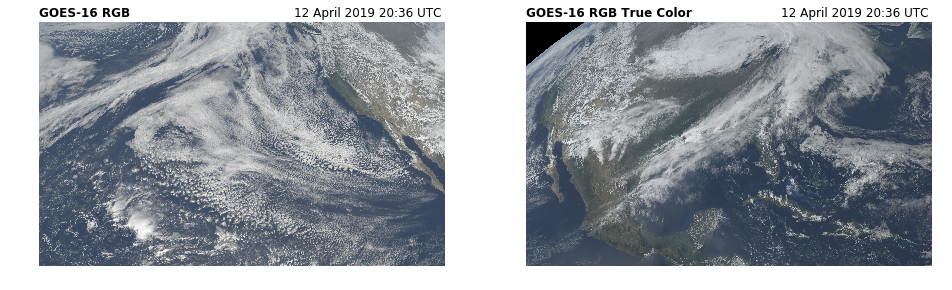

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

# The RGB using the raw veggie band
ax1.imshow(rgb17)
ax1.set_title('GOES-16 RGB', fontweight='semibold', loc='left', fontsize=12);
scan_start_17 = datetime.strptime(G17.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
ax1.set_title('%s' % scan_start_17.strftime('%d %B %Y %H:%M UTC '), loc='right');
ax1.axis('off')

# The RGB for the true color image
ax2.imshow(rgb16)
ax2.set_title('GOES-16 RGB True Color', fontweight='semibold', loc='left', fontsize=12);
scan_start_16 = datetime.strptime(G16.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
ax2.set_title('%s' % scan_start_16.strftime('%d %B %Y %H:%M UTC '), loc='right');
ax2.axis('off')

In [7]:
def make_proj(C):
    ######################################################################
    # Plot with `Cartopy`:  Geostationary Projection
    # ----------------------------------------------
    # 
    # The image above is not georeferenced. You can see the land and oceans, but we
    # do have enough information to draw state and country boundaries. From the
    # GOES-16 file, we can extract all the metadata needed to understand the map
    # projection. We will use this data to plot the image on a `Basemap`. The image
    # is in a [geostationary
    # projection](https://proj4.org/operations/projections/geos.html?highlight=geostationary).

    C['goes_imager_projection']

    ######################################################################
    #

    # Satellite height
    sat_h = C['goes_imager_projection'].perspective_point_height

    # Satellite longitude
    sat_lon = C['goes_imager_projection'].longitude_of_projection_origin

    # Satellite sweep
    sat_sweep = C['goes_imager_projection'].sweep_angle_axis

    semi_major = C['goes_imager_projection'].semi_major_axis
    semi_minor = C['goes_imager_projection'].semi_minor_axis

    # The projection x and y coordinates equals the scanning angle (in radians)
    # multiplied by the satellite height See details here:
    # https://proj4.org/operations/projections/geos.html?highlight=geostationary
    x = C['x'][:] * sat_h
    y = C['y'][:] * sat_h

    ######################################################################
    # The geostationary projection is the easiest way to plot the image on a
    # map. Essentially, we are stretching the image across a map with the same
    # projection and dimensions as the data.
    globe = ccrs.Globe(semimajor_axis=semi_major, semiminor_axis=semi_minor)
    geos = ccrs.Geostationary(central_longitude=sat_lon, 
                             satellite_height=sat_h, globe=globe)

    return geos, x, y

In [26]:
proj16, x16, y16 = make_proj(G16)
proj17, x17, y17 = make_proj(G17)

In [9]:
lc = ccrs.LambertConformal(central_longitude = -97.5,
                           standard_parallels = (38.5,38.5))

In [ ]:
plt.figure(figsize=[15, 12])
ax = plt.axes(projection=lc)

ax.imshow(rgb16, origin='upper',
          extent=(x16.min(), x16.max(), y16.min(), y16.max()), transform=proj16, interpolation='none')

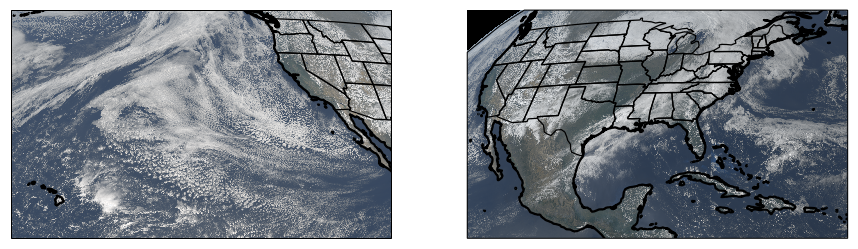

In [32]:
fig = plt.figure(figsize=(15, 12))

ax1 = fig.add_subplot(1, 2, 1, projection=proj17)
ax2 = fig.add_subplot(1, 2, 2, projection=proj16)


## GOES 17

ax1.imshow(rgb17, origin='upper', extent=(x17.min(), x17.max(), y17.min(), y17.max()),
          transform=proj17, interpolation='none')
ax1.coastlines(resolution='50m', color='black', linewidth=2.25)
ax1.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.25)

## GOES 16

ax2.imshow(rgb16, origin='upper', extent=(x16.min(), x16.max(), y16.min(), y16.max()),
          transform=proj16, interpolation='none')
ax2.coastlines(resolution='50m', color='black', linewidth=2.25)
ax2.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.25)

In [ ]:
fig = plt.figure(figsize=(15, 12))

lc = ccrs.LambertConformal(central_longitude=-97.5, standard_parallels=(38.5, 38.5))

ax1 = fig.add_subplot(1, 2, 1, projection=lc)
ax2 = fig.add_subplot(1, 2, 2, projection=lc)


## GOES 17

ax1.imshow(rgb17, origin='upper', extent=(x17.min(), x17.max(), y17.min(), y17.max()),
          transform=proj17, interpolation='none')
ax1.coastlines(resolution='50m', color='black', linewidth=2.25)
ax1.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.25)